In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import os
import yaml

import matplotlib.pyplot as plt
import cmocean as cm    

from xgboost import XGBRegressor
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, median_absolute_error

In [2]:
#This file contains configuration details like API keys and passwords
global_vars = yaml.safe_load(open('../config.yml', 'r') )

In [3]:
#This has custom functions - model evaluation and graphing
%run ./00_custom_functions.ipynb   

In [4]:
#Set base folders
cloud = True
if cloud:
    input_folder_root = global_vars['reconstruction_folder_cloud']
else:
    input_folder_root = global_vars['reconstruction_folder_local']
output_folder = input_folder_root #Because we are inputting and outputting processed files, the folder can be the same

full_dataset_file = input_folder_root + 'pCO2_LEAP_fco2-residual-full-dataset-preML_198201-202304.nc' #name of file from previous script
print(full_dataset_file)

/data/artemis/workspace/ds4114/reconstructions/pCO2_LEAP_fco2-residual-full-dataset-preML_198201-202304.nc


In [5]:
#This is where we set parameters for the algorithm

#The following two variables will cut the data to use for training (and prediction)
ml_start_yearmonth = '1982-01' 
ml_end_yearmonth = '2022-12'   

#This next variable sets how many models will be trained on different sets of months
#When number_of_runs = 5, the first model is trained on months 1-4 and evaluated on month 5. The next model on 2-5 and evaluated on 1. And so forth. 
number_of_runs = 5

#Next set the random seeds used for training (should match the number of runs)
if number_of_runs == 5:
    random_seeds = np.array([47,16,2,31,91])  #These are from historical work
else:
    random_seeds = np.random.randint(1,100,number_of_runs)  #or any set of numbers desired
print(f'Random Seeds {random_seeds}')

#The next variable is for the XGBoost method. These hyperparameters were determined via a grid search in previous iterations. 
best_params = {'max_depth': 9, 'n_estimators': 1000} 
jobs = -1         #Number of cores you have access to for model training; -1 for all available ones

#This variable is a list of features used for pCO2 Residual machine learning
feature_sel = ['sst','sst_anomaly','sss','sss_anomaly','chl_log','chl_log_anomaly','mld_log','xco2_trend','A','B','C','T0','T1']
target_sel = ['fco2_nonT']
for_final_sel = ['fco2','fco2_T'] #needed for model evaulation on reconstructed pco2

Random Seeds [47 16  2 31 91]


## Machine Learning

In [6]:
#These variables are based on the variables set at the top and are used to divide into train/test sets. No changes needed
ttime = pd.date_range(start=str(ml_start_yearmonth), end=str(ml_end_yearmonth),freq='MS') + np.timedelta64(14, 'D') 
month_run_number = []
for i, m in enumerate(ttime): month_run_number.append((i % number_of_runs) + 1)
month_traintest = xr.Dataset({'month_traintest':(['time'], month_run_number)}, coords={'time':(['time'],ttime)})

In [7]:
#Load the main dataframe created in the prior script
xrfull = xr.open_dataset(full_dataset_file)

xr_for_ml = xrfull.get(feature_sel + target_sel + for_final_sel) #variables needed for ML plus for getting back to pco2 from nonT
xr_for_ml = xr_for_ml.sel(time=slice(str(ml_start_yearmonth),str(ml_end_yearmonth)))  #filter for time frame we want
xr_for_ml = xr_for_ml.merge(month_traintest, compat='identical')   #add variable to determine train vs test

In [8]:
%%time
df = xr_for_ml.to_dataframe() #expensive function; need lots of RAM
#df.head(5)
#df.describe()
df_for_ml = df[(~df.isna().any(axis=1))]  #only keep points that are not null. Note that the target_sel has same number of points as the for_final_sel variables 
print(f'Number of points in time/space for training: {df_for_ml.shape[0]}')
#df_for_ml

df_for_recon = df.loc[:,feature_sel]
df_for_recon = df_for_recon[(~df_for_recon.isna().any(axis=1))]  #only predict on points with all variables globally
print(f'Number of points in time/space available to reconstruct: {df_for_recon.shape[0]}')
#df_for_recon

Number of points in time/space for training: 313433
Number of points in time/space available to reconstruct: 18198122
CPU times: user 7.05 s, sys: 10.9 s, total: 18 s
Wall time: 18 s


In [9]:
%%time
model_evaluation_ocean_co2_nonT = []
model_evaluation_ocean_co2 = []
ocean_co2_nonT_recon_list = np.empty([df_for_recon.shape[0], number_of_runs])  #placeholder np array for reconstructed data

for run in range(1,number_of_runs+1):

    X_train = df_for_ml[df_for_ml.month_traintest != run].loc[:,feature_sel]#.to_numpy()
    y_train = df_for_ml[df_for_ml.month_traintest != run].loc[:,target_sel]#.to_numpy().ravel()
    X_test = df_for_ml[df_for_ml.month_traintest == run].loc[:,feature_sel]#.to_numpy()
    y_test = df_for_ml[df_for_ml.month_traintest == run].loc[:,target_sel]#.to_numpy().ravel()
    #y_ocean_po2_test = df_for_ml[df_for_ml.month_traintest == run].loc[:,for_final_sel]  #The variables we need to reconstruct pco2 from pco2_nonT in the test set

    model = XGBRegressor(random_state=random_seeds[run-1], **best_params, n_jobs=jobs)
    print(f'----------Training Run {run} on '+datetime.datetime.now().strftime('%Y-%m-%d %H:%M')+'...----------')
    model.fit(X_train, y_train) 
    
    ############# Evaluation
    # Calculate some test error metrics and store in a dictionary
    y_pred_test = model.predict(X_test)

    print('-------Performance on ocean_co2_nonT-------')
    test_performance = evaluate_test(y_test.to_numpy().ravel(), y_pred_test)
    model_evaluation_ocean_co2_nonT.append(test_performance)
    print(test_performance)

    #print('-------Performance on ocean_co2 overall-------')
    #y_final = y_ocean_co2_test[target_sel].to_numpy().ravel()   # Real pCO2 from SOCAT (for test set)
    #y_ocean_co2t = y_ocean_co2_test['fpco2'+'_T'].to_numpy().ravel() # pCO2_T (already calculated)
    #y_pred_final = y_pred_test + y_ocean_co2t
    #ocean_co2_performance = evaluate_test(y_final, y_pred_final)
    #model_evaluation_ocean_co2.append(ocean_co2_performance)
    #print(ocean_co2_performance)
    
    ############# Reconstruction
    print(f'----------Reconstructing Globally Run {run} on '+datetime.datetime.now().strftime('%Y-%m-%d %H:%M')+'...----------')
    ocean_co2_nonT_recon = model.predict(df_for_recon)
    ocean_co2_nonT_recon_list[:,run-1] = ocean_co2_nonT_recon
    print(f'Run {run} Complete')
    print('\n\n')

----------Training Run 1 on 2023-07-01 16:00...----------
-------Performance on ocean_co2_nonT-------
{'mse': 375.21887, 'mae': 12.645772, 'medae': 8.236731, 'max_error': 230.21997, 'bias': 0.59604454, 'r2': 0.8206470340393518, 'corr': 0.9061792774735186, 'cent_rmse': 19.36139516149108, 'stdev': 42.29624, 'amp_ratio': 0.803209, 'stdev_ref': 45.739147, 'range_ref': 756.0307, 'iqr_ref': 46.693206787109375}
----------Reconstructing Globally Run 1 on 2023-07-01 16:05...----------
Run 1 Complete



----------Training Run 2 on 2023-07-01 16:06...----------
-------Performance on ocean_co2_nonT-------
{'mse': 365.70996, 'mae': 12.487388, 'medae': 8.194368, 'max_error': 304.40344, 'bias': -0.3287118, 'r2': 0.8202377587302228, 'corr': 0.9062471153675972, 'cent_rmse': 19.120720174968298, 'stdev': 42.29706, 'amp_ratio': 0.91284543, 'stdev_ref': 45.104427, 'range_ref': 625.23694, 'iqr_ref': 47.319732666015625}
----------Reconstructing Globally Run 2 on 2023-07-01 16:11...----------
Run 2 Complete



In [10]:
#now combine all runs into one set
ocean_co2_nonT_recon_avg = ocean_co2_nonT_recon_list.mean(axis=1)
df_for_recon['ocean_co2_nonT_recon_avg'] = ocean_co2_nonT_recon_avg

In [11]:
xr_ocean_co2_nonT_recon = df_for_recon.ocean_co2_nonT_recon_avg.to_xarray()  #can be computationally costly

In [12]:
target_var_name = str(target_sel[0]).replace('_nonT','')  #just 'fco2' or 'pco2' for naming things
xr_after_ml = xr_for_ml.merge(xr_ocean_co2_nonT_recon, compat='identical')
xr_after_ml = xr_after_ml.assign(ocean_co2_recon=xr_after_ml[target_var_name+'_T']+xr_after_ml.ocean_co2_nonT_recon_avg)
xr_after_ml = xr_after_ml.transpose('time','ylat','xlon')
xr_after_ml = xr_after_ml.rename({'ocean_co2_nonT_recon_avg': target_var_name+'_nonT_recon_avg'
                                 ,'ocean_co2_recon': target_var_name+'_recon'
                                })
#xr_after_ml

In [13]:
print( str(target_sel[0]).replace('_nonT','') )
xr_after_ml

fco2


<xarray.Dataset>
Dimensions:              (time: 492, xlon: 360, ylat: 180)
Coordinates:
  * ylat                 (ylat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time                 (time) datetime64[ns] 1982-01-15 ... 2022-12-15
  * xlon                 (xlon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables: (12/19)
    sst                  (time, ylat, xlon) float32 nan nan ... -1.737 -1.717
    sst_anomaly          (time, ylat, xlon) float32 nan nan ... 0.009669
    sss                  (time, ylat, xlon) float32 nan nan nan ... 31.86 31.86
    sss_anomaly          (time, ylat, xlon) float32 nan nan ... 0.4066 0.4066
    chl_log              (time, ylat, xlon) float64 nan nan nan ... nan nan nan
    chl_log_anomaly      (time, ylat, xlon) float64 nan nan nan ... nan nan nan
    ...                   ...
    fco2_nonT            (time, ylat, xlon) float32 nan nan nan ... nan nan nan
    fco2                 (time, ylat, xlon) float32 nan nan nan ... nan nan nan
    fco2_T               (time, ylat, xlon) float32 nan nan nan ... nan nan nan
    month_traintest      (time) int64 1 2 3 4 5 1 2 3 4 5 ... 4 5 1 2 3 4 5 1 2
    fco2_nonT_recon_avg  (time, ylat, xlon) float64 nan nan nan ... nan nan nan
    fco2_recon           (time, ylat, xlon) float64 nan nan nan ... nan nan nan

In [14]:
#Perform some clean up before exporting
xr_out = xr.Dataset({target_var_name+'_reconstructed':(['time','ylat','xlon'],xr_after_ml[target_var_name+'_recon'].data)
                    },coords={'time':(['time'],xr_after_ml.time.values),'ylat':(['ylat'],xr_after_ml.ylat.values),'xlon':(['xlon'],xr_after_ml.xlon.values)})

xr_out['fco2_reconstructed'].attrs['description'] = "fCO2-Residual (XGBoost ensemble mean)"
xr_out.attrs['hyperparameters'] = str(best_params)
xr_out.attrs['training_data'] = str(full_dataset_file)
xr_out.attrs['training_features'] = str(feature_sel)
xr_out.attrs['created'] = str(datetime.datetime.now())
xr_out.attrs['methodology'] = "Bennington et al. (2022), JAMES"
#xr_out.attrs['code'] = "/home/vbennington/pCO2_Residual/calc_fluxes.ipynb"
xr_out

<xarray.Dataset>
Dimensions:             (time: 492, xlon: 360, ylat: 180)
Coordinates:
  * time                (time) datetime64[ns] 1982-01-15 ... 2022-12-15
  * ylat                (ylat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * xlon                (xlon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    fco2_reconstructed  (time, ylat, xlon) float64 nan nan nan ... nan nan nan
Attributes:
    hyperparameters:    {'max_depth': 9, 'n_estimators': 1000}
    training_data:      /data/artemis/workspace/ds4114/reconstructions/pCO2_L...
    training_features:  ['sst', 'sst_anomaly', 'sss', 'sss_anomaly', 'chl_log...
    created:            2023-07-01 16:28:10.649297
    methodology:        Bennington et al. (2022), JAMES

In [15]:
#output
output_netcdf_with_date(xr_out, output_folder+'', 'pCO2_LEAP_XGBoost-'+target_var_name+'-residual-reconstructed')

Saved pCO2_LEAP_XGBoost-fco2-residual-reconstructed_198201-202212.nc to /data/artemis/workspace/ds4114/reconstructions/


## View Results

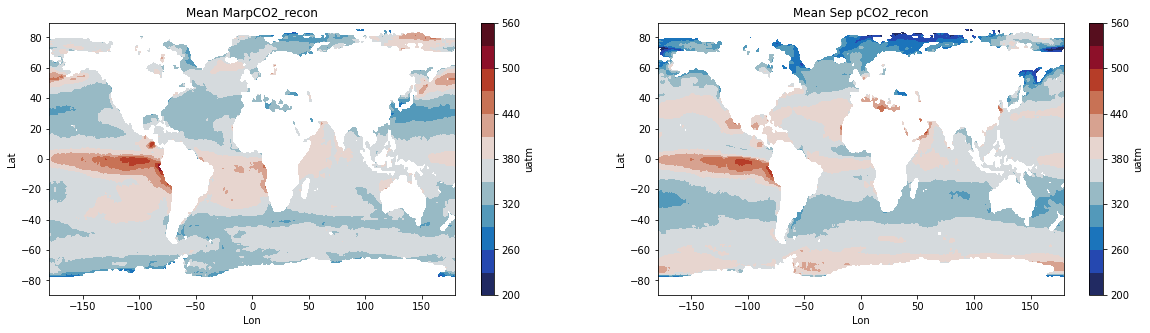

In [16]:
#Plot maps at different points in time/month to view reconstruction results

#varname, plot_data ='pCO2_T' , xr_after_ml.pco2_T.groupby("time.month").mean("time")
varname, plot_data ='pCO2_recon' , xr_after_ml[target_var_name+'_recon'].groupby("time.month").mean("time")
levelspace = np.linspace(200,560,13)
fig,ax = plt.subplots(1,2,figsize=(20,5))
x0=ax[0].contourf(xr_after_ml.xlon,xr_after_ml.ylat,plot_data[2,:,:],levels=levelspace,cmap=cm.cm.balance)
x0=ax[1].contourf(xr_after_ml.xlon,xr_after_ml.ylat,plot_data[8,:,:],levels=levelspace,cmap=cm.cm.balance)

ax[0].set_title("Mean Mar"+ varname); ax[1].set_title("Mean Sep "+varname);
ax[0].set_xlabel('Lon'); ax[0].set_ylabel('Lat');
ax[1].set_xlabel('Lon'); ax[1].set_ylabel('Lat');
plt.colorbar(x0, ax=ax[0]).set_label('uatm');
plt.colorbar(x0, ax=ax[1]).set_label('uatm');

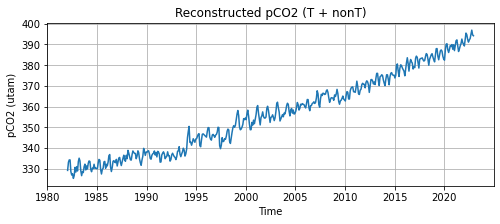

In [17]:
plt_y = xr_after_ml[target_var_name+'_recon'].mean("ylat").mean('xlon') #average global
#plt_y = xr_after_ml.pco2_recon.sel(ylat=.5, xlon=.5)  #just at one point
fig = plt.figure(figsize=(8,3))
plt.plot(ttime,plt_y)
plt.grid(True)
plt.title('Reconstructed pCO2 (T + nonT)'); plt.xlabel('Time'); plt.ylabel('pCO2 (utam)');

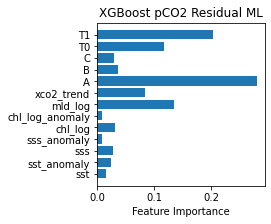

In [19]:
fig = plt.figure(figsize=(3,3))
plt.barh(feature_sel, model.feature_importances_)  #note, this is only for the last run
plt.xlabel("Feature Importance")
plt.title('XGBoost pCO2 Residual ML');